In [1]:
import numpy as np

from qiskit import QuantumCircuit, execute, Aer
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

In [151]:
def oracle(state, n_qubits):
    qc = QuantumCircuit(n_qubits+1)
    bin_state = "".join(str(b) for b in np.binary_repr(state, n_qubits))
    
    for b, i in zip(bin_state, range(len(bin_state))):
        if b == "0":
            qc.x(len(bin_state) - 1 - i)
          
    qc.mcx(control_qubits=list(range(n_qubits)), target_qubit=n_qubits)
    
    for b, i in zip(bin_state, range(len(bin_state))):
        if b == "0":
            qc.x(len(bin_state) - 1 - i)
    
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    
    return oracle_gate
    

In [148]:
def diffuser(n_qubits):
    qc = QuantumCircuit(n_qubits+1)
    
    qc.h(range(n_qubits))
    qc.append(oracle(state=0, n_qubits=n_qubits), range(n_qubits+1))
    qc.h(range(n_qubits))
    
    dif_gate = qc.to_gate()
    dif_gate.name = "Diff"
    
    return dif_gate

In [214]:
def groover_algorithm(n_qubits, states, repetitions):
    qc = QuantumCircuit(n_qubits+1, n_qubits)
    
#     prepare ancilla qubit
    qc.x(n_qubits)
    qc.h(n_qubits)
    
#    create uniform superposition
    qc.h(range(n_qubits))
    
    for rep in range(repetitions):
        qc.barrier()
        for state in states:
            qc.append(oracle(state, n_qubits), range(n_qubits+1))
            
        qc.barrier()
        qc.append(diffuser(n_qubits), range(n_qubits+1))
        if rep == repetitions-1:
            qc.barrier()
    
    qc.measure(range(n_qubits), range(n_qubits))
    
    return qc
    
    

In [246]:
def get_repetitions(n_qubits, state_len):
    return int(np.floor(np.pi*np.sqrt(2**n_qubits / state_len)/4))

In [265]:
n_qubits = 4
state = [3, 11, 15]
repetitions = get_repetitions(n_qubits, len(state))
print("Repetitions : ", repetitions)
groover_circuit = groover_algorithm(n_qubits, state, repetitions)

Repetitions :  1


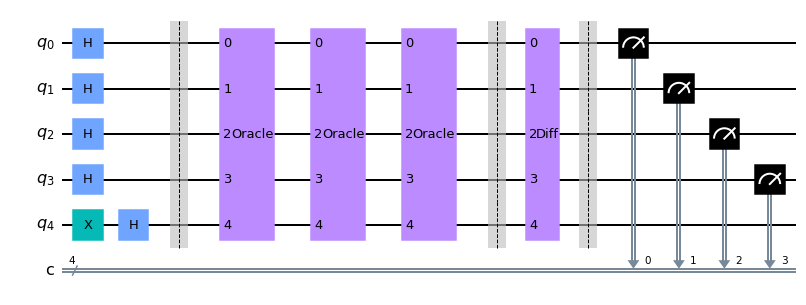

In [266]:
groover_circuit.decompose(reps=0).draw('mpl')

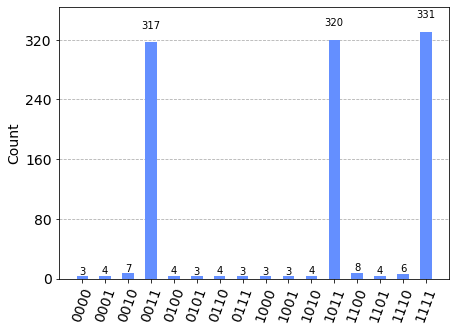

In [267]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(groover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)